# 🔬 Multi-Lag & Seasonal Learning Analysis

**Purpose:** Detailed analysis of advanced learning features - multi-lag time delays and seasonal adaptations

---

### 📖 How to Use This Notebook

**What it shows:** Deep dive into the enhanced learning mechanisms

**Key sections:**
1. **Multi-Lag Coefficients** - Time-delayed effects of PV, fireplace, TV (how past influences present)
2. **Seasonal Modulation** - Monthly variation patterns (cos/sin curves showing seasonal adjustments)
3. **Correlation Analysis** - Statistical validation of learned lag patterns
4. **Summer Learning Status** - HVAC-off data collection for clean baseline learning
5. **Recommendations** - Actionable insights based on learning maturity

**How to interpret:**

**Multi-lag patterns:**
- **PV lags (30-120min):** Show how solar heat accumulates and releases over time
  - Later lags often higher = thermal mass effect
  - Total > 0.01°C/100W = meaningful PV contribution
- **Fireplace lags (0-90min):** Show immediate + lingering heat from combustion
  - Immediate lag usually highest = direct radiant heat
  - Total > 0.2°C/hr = significant fireplace impact
- **TV lags (0-30min):** Small but measurable electronic heat
  - Total 0.01-0.04°C = typical for 100-200W device

**Seasonal curves:**
- **Values > 1.0** = Heat source more effective this month (e.g., winter PV at 1.3x)
- **Values < 1.0** = Heat source less effective (e.g., summer PV at 0.7x)
- **Flat at 1.0** = No seasonal variation (e.g., fireplace)
- **Range 0.5-1.5x** = Normal seasonal variation

**Activation status:**
- **Multi-lag:** Needs 200+ training cycles to activate
- **Seasonal:** Needs 100+ HVAC-off samples (collected during summer)
- **Before activation:** Uses simple single coefficients (no time delays or seasonal adjustments)

**When to run:** 
- After reaching 200 training cycles (multi-lag activated)
- During/after summer (seasonal learning active)
- Monthly to track learning evolution
- When diagnosing unexpected behavior

In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import pickle

from src.physics_model import RealisticPhysicsModel
from src import config

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

## 1. Load Current Model State

In [2]:
# Load trained model
try:
    with open(config.MODEL_FILE, 'rb') as f:
        model_data = pickle.load(f)
    
    if isinstance(model_data, dict) and 'model' in model_data:
        physics_model = model_data['model']
        print("✓ Loaded physics model from saved state")
        print(f"  Training count: {physics_model.training_count}")
    else:
        physics_model = RealisticPhysicsModel()
        print("⚠ No saved physics model, using new instance")
except FileNotFoundError:
    physics_model = RealisticPhysicsModel()
    print("⚠ No model file found, using new instance")

✓ Loaded physics model from saved state
  Training count: 3072


## 2. Visualize Multi-Lag Coefficients

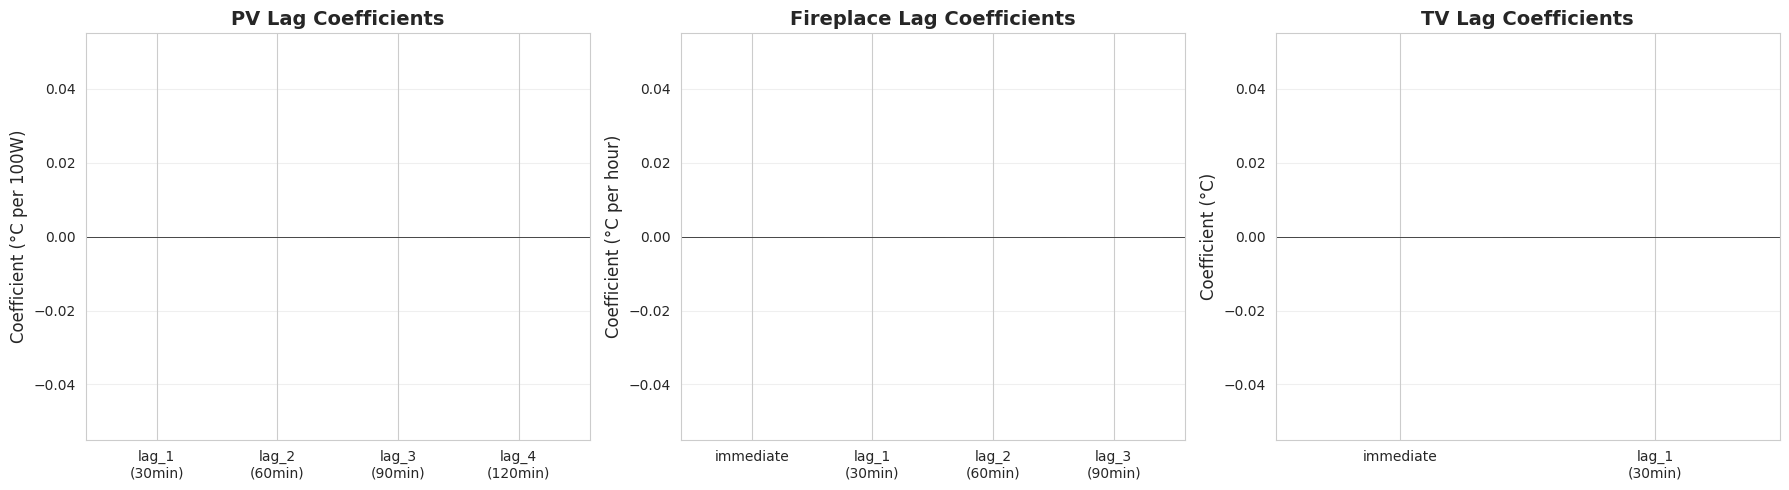


MULTI-LAG COEFFICIENT SUMMARY

PV (per 100W):
  lag_1     :  0.00000 °C
  lag_2     :  0.00000 °C
  lag_3     :  0.00000 °C
  lag_4     :  0.00000 °C
  Total:       0.00000 °C

Fireplace (per hour on):
  immediate :  0.00000 °C
  lag_1     :  0.00000 °C
  lag_2     :  0.00000 °C
  lag_3     :  0.00000 °C
  Total:       0.00000 °C

TV:
  immediate :  0.00000 °C
  lag_1     :  0.00000 °C
  Total:       0.00000 °C


In [3]:
# PV Lag Distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# PV
pv_lags = ['lag_1\n(30min)', 'lag_2\n(60min)', 'lag_3\n(90min)', 'lag_4\n(120min)']
pv_values = [physics_model.pv_coeffs[k] for k in ['lag_1', 'lag_2', 'lag_3', 'lag_4']]
axes[0].bar(pv_lags, pv_values, color='orange', alpha=0.7)
axes[0].set_title('PV Lag Coefficients', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Coefficient (°C per 100W)', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)
axes[0].axhline(0, color='black', linewidth=0.5)

# Fireplace
fp_lags = ['immediate', 'lag_1\n(30min)', 'lag_2\n(60min)', 'lag_3\n(90min)']
fp_values = [physics_model.fireplace_coeffs[k] for k in ['immediate', 'lag_1', 'lag_2', 'lag_3']]
axes[1].bar(fp_lags, fp_values, color='red', alpha=0.7)
axes[1].set_title('Fireplace Lag Coefficients', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Coefficient (°C per hour)', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)
axes[1].axhline(0, color='black', linewidth=0.5)

# TV
tv_lags = ['immediate', 'lag_1\n(30min)']
tv_values = [physics_model.tv_coeffs[k] for k in ['immediate', 'lag_1']]
axes[2].bar(tv_lags, tv_values, color='blue', alpha=0.7)
axes[2].set_title('TV Lag Coefficients', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Coefficient (°C)', fontsize=12)
axes[2].grid(axis='y', alpha=0.3)
axes[2].axhline(0, color='black', linewidth=0.5)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("MULTI-LAG COEFFICIENT SUMMARY")
print("="*60)
print("\nPV (per 100W):")
for k, v in physics_model.pv_coeffs.items():
    print(f"  {k:10s}: {v:8.5f} °C")
print(f"  Total:      {sum(physics_model.pv_coeffs.values()):8.5f} °C")

print("\nFireplace (per hour on):")
for k, v in physics_model.fireplace_coeffs.items():
    print(f"  {k:10s}: {v:8.5f} °C")
print(f"  Total:      {sum(physics_model.fireplace_coeffs.values()):8.5f} °C")

print("\nTV:")
for k, v in physics_model.tv_coeffs.items():
    print(f"  {k:10s}: {v:8.5f} °C")
print(f"  Total:      {sum(physics_model.tv_coeffs.values()):8.5f} °C")

## 3. Seasonal Modulation Analysis

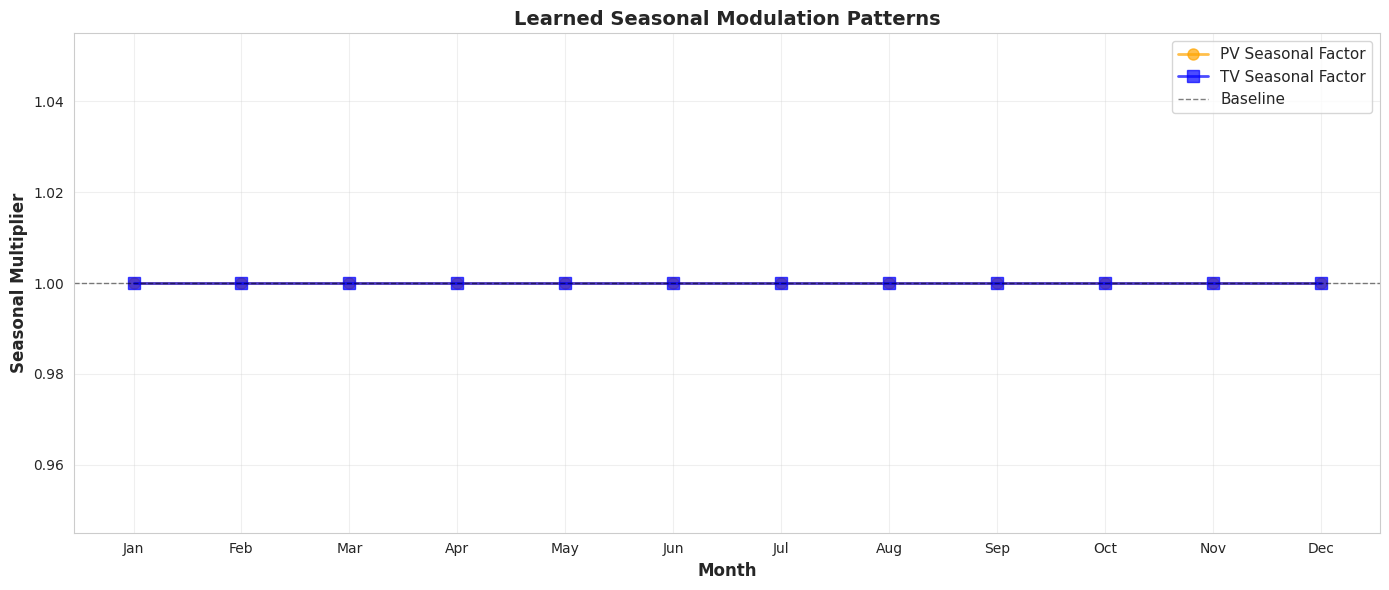


SEASONAL MODULATION COEFFICIENTS

PV:
  cos coeff:  0.00000
  sin coeff:  0.00000
  Range:     1.00x to 1.00x

TV:
  cos coeff:  0.00000
  sin coeff:  0.00000
  Range:     1.00x to 1.00x


In [4]:
# Generate seasonal curves
months = np.arange(1, 13)
month_radians = 2 * np.pi * months / 12
month_cos = np.cos(month_radians)
month_sin = np.sin(month_radians)

# Calculate seasonal factors
pv_seasonal = 1.0 + (physics_model.pv_seasonal_cos * month_cos + 
                     physics_model.pv_seasonal_sin * month_sin)
tv_seasonal = 1.0 + (physics_model.tv_seasonal_cos * month_cos + 
                     physics_model.tv_seasonal_sin * month_sin)

# Plot
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(months, pv_seasonal, 'o-', color='orange', linewidth=2, 
        markersize=8, label='PV Seasonal Factor', alpha=0.7)
ax.plot(months, tv_seasonal, 's-', color='blue', linewidth=2, 
        markersize=8, label='TV Seasonal Factor', alpha=0.7)
ax.axhline(1.0, color='black', linestyle='--', linewidth=1, alpha=0.5, label='Baseline')
ax.set_xlabel('Month', fontsize=12, fontweight='bold')
ax.set_ylabel('Seasonal Multiplier', fontsize=12, fontweight='bold')
ax.set_title('Learned Seasonal Modulation Patterns', fontsize=14, fontweight='bold')
ax.set_xticks(months)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("SEASONAL MODULATION COEFFICIENTS")
print("="*60)
print(f"\nPV:")
print(f"  cos coeff: {physics_model.pv_seasonal_cos:8.5f}")
print(f"  sin coeff: {physics_model.pv_seasonal_sin:8.5f}")
print(f"  Range:     {pv_seasonal.min():.2f}x to {pv_seasonal.max():.2f}x")
print(f"\nTV:")
print(f"  cos coeff: {physics_model.tv_seasonal_cos:8.5f}")
print(f"  sin coeff: {physics_model.tv_seasonal_sin:8.5f}")
print(f"  Range:     {tv_seasonal.min():.2f}x to {tv_seasonal.max():.2f}x")

## 4. Learning Progress Tracking

In [5]:
# Track sample counts for different learning mechanisms
print("="*60)
print("LEARNING SAMPLE COUNTS")
print("="*60)
print(f"\nTotal training cycles: {physics_model.training_count}")
print(f"\nMulti-lag tracking:")
print(f"  PV effects:        {len(physics_model.pv_effects_detailed)}")
print(f"  Fireplace effects: {len(physics_model.fireplace_effects_detailed)}")
print(f"  TV effects:        {len(physics_model.tv_effects_detailed)}")
print(f"\nSummer learning:")
print(f"  HVAC-off samples:  {len(physics_model.hvac_off_tracking)}")
print(f"\nLegacy tracking:")
print(f"  PV (simple):       {len(physics_model.pv_effects)}")
print(f"  Fireplace (simple): {len(physics_model.fireplace_effects)}")
print(f"  TV (simple):       {len(physics_model.tv_effects)}")

LEARNING SAMPLE COUNTS

Total training cycles: 3072

Multi-lag tracking:
  PV effects:        20
  Fireplace effects: 0
  TV effects:        0

Summer learning:
  HVAC-off samples:  0

Legacy tracking:
  PV (simple):       107
  Fireplace (simple): 0
  TV (simple):       194


## 5. Lag Correlation Analysis

Analyze which time lags show strongest correlation with temperature changes.

In [6]:
# Analyze PV lag correlations if enough data
if len(physics_model.pv_effects_detailed) >= 50:
    recent = physics_model.pv_effects_detailed[-100:]
    changes = np.array([e['actual_change'] for e in recent])
    
    correlations = []
    for lag_idx in range(1, 5):
        lag_powers = np.array([e['power_history'][-1-lag_idx] for e in recent])
        if np.std(lag_powers) > 0.1:
            corr = np.corrcoef(lag_powers, changes)[0, 1]
            correlations.append(corr)
        else:
            correlations.append(0.0)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    lags = ['30min', '60min', '90min', '120min']
    colors = ['red' if c < 0 else 'green' for c in correlations]
    ax.bar(lags, correlations, color=colors, alpha=0.7)
    ax.set_title('PV Power Lag Correlation with Temperature Change', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Time Lag', fontsize=12)
    ax.set_ylabel('Correlation Coefficient', fontsize=12)
    ax.axhline(0, color='black', linewidth=1)
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*60)
    print("PV LAG CORRELATION ANALYSIS")
    print("="*60)
    for lag, corr in zip(lags, correlations):
        print(f"  {lag:7s}: {corr:7.4f}")
    print(f"\n  Peak lag: {lags[np.argmax(correlations)]}")
    print(f"  Peak corr: {max(correlations):.4f}")
else:
    print("⚠ Not enough PV data for correlation analysis (need 50+ samples)")

⚠ Not enough PV data for correlation analysis (need 50+ samples)


## 6. Summer vs Winter Learning Comparison

In [7]:
# Analyze summer learning effectiveness
if len(physics_model.hvac_off_tracking) >= 20:
    summer_data = physics_model.hvac_off_tracking[-100:]
    
    # Extract PV samples from summer
    pv_summer = [s for s in summer_data if s['pv'] > 100]
    
    if len(pv_summer) > 10:
        pv_powers = [s['pv'] for s in pv_summer]
        pv_changes = [s['actual_change'] for s in pv_summer]
        
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.scatter(pv_powers, pv_changes, alpha=0.5, s=50)
        ax.set_xlabel('PV Power (W)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Temperature Change (°C/30min)', fontsize=12, fontweight='bold')
        ax.set_title('PV Effect During HVAC-Off Periods (Clean Signal)', 
                     fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Add trend line
        z = np.polyfit(pv_powers, pv_changes, 1)
        p = np.poly1d(z)
        x_line = np.linspace(min(pv_powers), max(pv_powers), 100)
        ax.plot(x_line, p(x_line), 'r--', linewidth=2, alpha=0.7, 
                label=f'Trend: {z[0]:.6f}°C/W')
        ax.legend()
        
        plt.tight_layout()
        plt.show()
        
        print("\n" + "="*60)
        print("SUMMER LEARNING EFFECTIVENESS")
        print("="*60)
        print(f"\nHVAC-off samples: {len(summer_data)}")
        print(f"PV active samples: {len(pv_summer)}")
        print(f"\nLearned PV coefficient (summer clean signal):")
        print(f"  {z[0]*100:.5f} °C per 100W")
    else:
        print("⚠ Not enough summer PV data")
else:
    print("⚠ Not enough HVAC-off tracking data (need 20+ samples)")

⚠ Not enough HVAC-off tracking data (need 20+ samples)


## 7. Recommendations

Based on the analysis above, here are recommendations for optimal performance.

In [8]:
print("="*60)
print("SYSTEM RECOMMENDATIONS")
print("="*60)

# Check if multi-lag is learning properly
if physics_model.training_count < 200:
    print("\n⚠ EARLY STAGE (< 200 cycles)")
    print("  - Multi-lag learning not yet active")
    print("  - Wait for 200+ training cycles for enhanced features")
    print("  - Currently using simple coefficients")
elif len(physics_model.pv_effects_detailed) < 50:
    print("\n⚠ INSUFFICIENT PV DATA")
    print("  - Need 50+ PV samples for reliable lag learning")
    print("  - Ensure PV sensors are working correctly")
else:
    print("\n✓ MULTI-LAG LEARNING ACTIVE")
    pv_total = sum(physics_model.pv_coeffs.values())
    if pv_total > 0.0001:
        print(f"  - PV total effect: {pv_total:.5f} °C/100W")
        max_lag = max(physics_model.pv_coeffs.items(), key=lambda x: x[1])
        print(f"  - Peak lag: {max_lag[0]} ({max_lag[1]:.5f})")
    else:
        print("  - PV coefficients still near zero (early learning)")

# Check seasonal learning
if len(physics_model.hvac_off_tracking) < 100:
    print("\n⚠ SEASONAL LEARNING NOT YET ACTIVE")
    print(f"  - Need 100+ HVAC-off samples (have {len(physics_model.hvac_off_tracking)})")
    print("  - Seasonal modulation at default (no effect)")
else:
    print("\n✓ SEASONAL LEARNING ACTIVE")
    if abs(physics_model.pv_seasonal_cos) > 0.01 or abs(physics_model.pv_seasonal_sin) > 0.01:
        print("  - PV seasonal modulation learned")
        pv_seas_range = (1.0 + physics_model.pv_seasonal_cos * np.cos(np.linspace(0, 2*np.pi, 12)) + 
                        physics_model.pv_seasonal_sin * np.sin(np.linspace(0, 2*np.pi, 12)))
        print(f"  - PV seasonal range: {pv_seas_range.min():.2f}x to {pv_seas_range.max():.2f}x")
    else:
        print("  - PV seasonal modulation still learning")

# Overall status
print("\n" + "="*60)
if physics_model.training_count >= 1000:
    print("✓ SYSTEM MATURE - Enhanced features fully operational")
elif physics_model.training_count >= 200:
    print("⚙ SYSTEM LEARNING - Enhanced features active, converging")
else:
    print("🌱 SYSTEM INITIALIZING - Wait for enhanced features to activate")
print("="*60)

SYSTEM RECOMMENDATIONS

⚠ INSUFFICIENT PV DATA
  - Need 50+ PV samples for reliable lag learning
  - Ensure PV sensors are working correctly

⚠ SEASONAL LEARNING NOT YET ACTIVE
  - Need 100+ HVAC-off samples (have 0)
  - Seasonal modulation at default (no effect)

✓ SYSTEM MATURE - Enhanced features fully operational
